*Projeto Capítulo 2*

---
**Aluno:** Adalberto Ferreira Barbosa Junior<br>
**Matrícula:** 201905439


# Setup Inicial

In [6]:
# Imports básicos do Python
import sys
from packaging import version
import sklearn
# Imports de manipulação de dados e utilitários
import numpy as np
import pandas as pd
from pathlib import Path
import tarfile
import urllib.request

# Imports para visualização
import matplotlib.pyplot as plt

# Imports do PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0+cu124


# Configurações Adicionais (Fontes e Salvamento de Figuras)

In [5]:
# Define tamanhos de fonte padrão para Matplotlib
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Cria o diretório para salvar as imagens (se não existir)
IMAGES_PATH = Path() / "images" / "end_to_end_project_pytorch"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Função para salvar figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Define uma semente aleatória para reprodutibilidade (Numpy e PyTorch)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Obter os Dados

Vamos definir uma função para baixar e carregar os dados de habitação da Califórnia.

In [7]:
# Imports necessários (redundante se a célula de setup executou corretamente)
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# Função para carregar os dados de habitação
def download_data():
    # Define o caminho para o arquivo tarball
    file_path = Path("datasets/housing.tgz")

    # Verifica se o arquivo já existe
    if not file_path.is_file():
        # Cria o diretório 'datasets' se não existir
        Path("datasets").mkdir(parents=True, exist_ok=True)
        # URL para baixar os dados
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        # Baixa o arquivo
        print("Baixando os dados...")
        urllib.request.urlretrieve(url, file_path)
        print("Download concluído.")

    # Extrai o conteúdo do arquivo tarball
    print("Extraindo arquivos...")
    with tarfile.open(file_path) as housing:
        housing.extractall(path="datasets")
    print("Extração concluída.")

    # Lê o arquivo CSV extraído usando Pandas
    csv_path = Path("datasets/housing/housing.csv")
    return pd.read_csv(csv_path)

# Carrega os dados
housing = download_data()
print("Dados carregados com sucesso!")

Baixando os dados...
Download concluído.
Extraindo arquivos...
Extração concluída.
Dados carregados com sucesso!


C:\Users\Adalberto\AppData\Local\Temp\ipykernel_22728\3814722227.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing.extractall(path="datasets")


# Explorar os Dados

In [8]:
# Mostra as primeiras 5 linhas do DataFrame
print("Primeiras linhas do DataFrame:")
housing.head()

Primeiras linhas do DataFrame:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
# Exibe um resumo conciso do DataFrame, incluindo tipos de dados e contagem de não nulos
print("\nInformações do DataFrame:")
housing.info()


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


A coluna `total_bedrooms` tem valores ausentes (20433 não nulos em 20640). A coluna `ocean_proximity` é do tipo `object`, provavelmente categórica. Vamos verificar suas categorias.

In [10]:
# Conta a frequência de cada categoria na coluna 'ocean_proximity'
print("\nContagem de valores para 'ocean_proximity':")
housing["ocean_proximity"].value_counts()


Contagem de valores para 'ocean_proximity':


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [11]:
# Mostra um resumo estatístico das colunas numéricas
print("\nResumo estatístico das colunas numéricas:")
housing.describe()


Resumo estatístico das colunas numéricas:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Agora, vamos visualizar a distribuição dos dados numéricos usando histogramas.

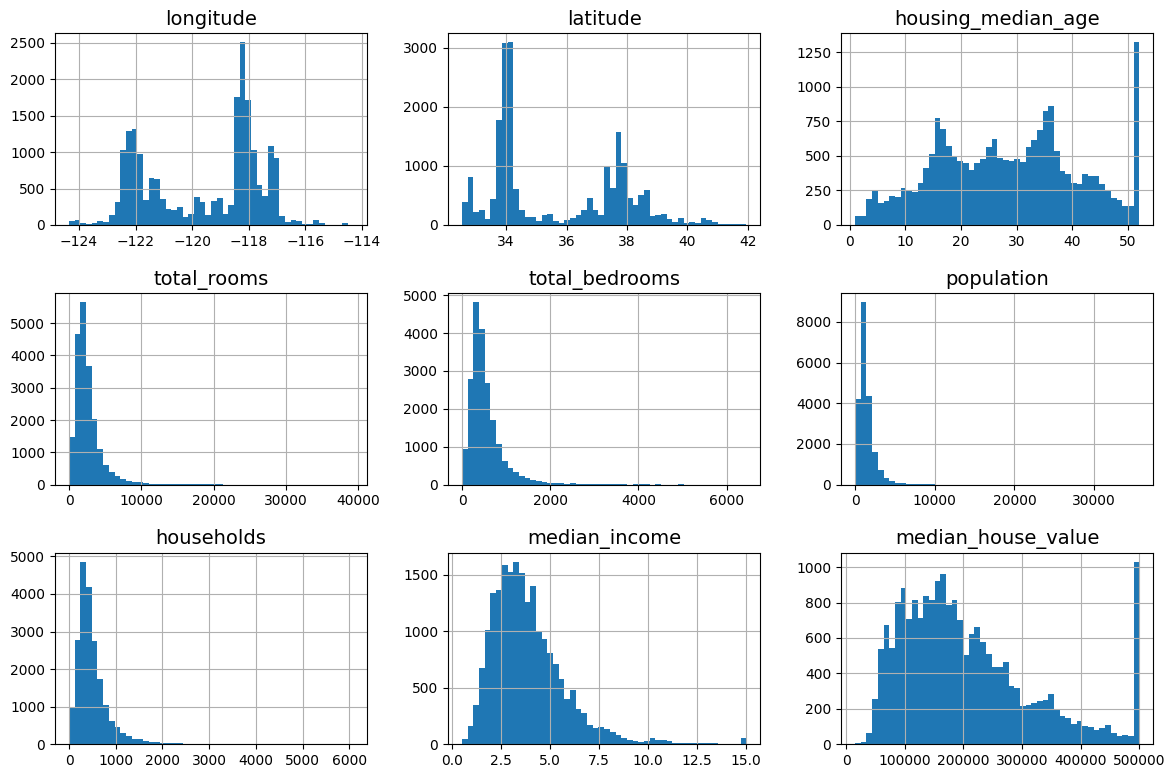

In [12]:
# Gera histogramas para todas as colunas numéricas do DataFrame
# 'bins=50' define o número de barras em cada histograma
# 'figsize=(12, 8)' define o tamanho da figura
housing.hist(bins=50, figsize=(12, 8))

# Salva a figura gerada
save_fig("attribute_histogram_plots")

# Exibe os histogramas
plt.show()

# Criar um Conjunto de Teste

Primeiro, criamos uma categoria de renda para estratificação. A renda mediana está em dezenas de milhares de dólares. Vamos agrupar as rendas em categorias.

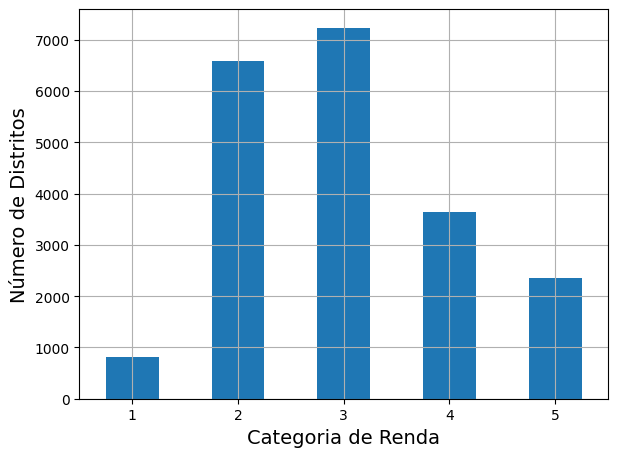

In [13]:
# Cria uma coluna categórica 'income_cat' baseada na 'median_income'
# pd.cut divide a 'median_income' em intervalos (bins) definidos
# np.inf representa infinito, para capturar valores acima de 6
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Visualiza a distribuição das categorias de renda criadas
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Categoria de Renda")
plt.ylabel("Número de Distritos")
save_fig("housing_income_cat_bar_plot") # Salva a figura
plt.show()

Agora, realizamos a divisão estratificada usando a coluna `income_cat`.

In [14]:
from sklearn.model_selection import train_test_split

# Realiza a divisão estratificada dos dados
# test_size=0.2 define que 20% dos dados irão para o conjunto de teste
# stratify=housing["income_cat"] garante que a proporção das categorias de renda seja mantida
# random_state=42 garante a reprodutibilidade da divisão
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Verifica a proporção das categorias de renda no conjunto de teste estratificado
print("Proporção das categorias de renda no conjunto de teste estratificado:")
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

Proporção das categorias de renda no conjunto de teste estratificado:
income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64


Vamos comparar a distribuição da categoria de renda no conjunto de teste estratificado, no conjunto de teste aleatório (sem estratificação) e no conjunto de dados completo.

In [15]:
# Função auxiliar para calcular as proporções
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# Cria um conjunto de teste aleatório para comparação
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Cria um DataFrame para comparar as proporções
compare_props = pd.DataFrame({
    "Total %": income_cat_proportions(housing),
    "Estratificado %": income_cat_proportions(strat_test_set),
    "Aleatório %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Categoria de Renda"

# Calcula o erro percentual da amostragem estratificada e aleatória em relação ao total
compare_props["Erro Estrat. %"] = (compare_props["Estratificado %"] /
                                   compare_props["Total %"] - 1)
compare_props["Erro Aleat. %"] = (compare_props["Aleatório %"] /
                                  compare_props["Total %"] - 1)

# Exibe o DataFrame com as comparações (arredondado para 2 casas decimais)
print("Comparação das proporções das categorias de renda:")
(compare_props * 100).round(2)

# Nota: O erro percentual na amostragem estratificada é significativamente menor,
# mostrando que ela representa melhor a distribuição original das rendas.

Comparação das proporções das categorias de renda:


,Total %,Estratificado %,Aleatório %,Erro Estrat. %,Erro Aleat. %
Categoria de Renda,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


Finalmente, removemos a coluna `income_cat`, pois ela foi usada apenas para a estratificação e não fará parte dos dados de treinamento/teste.

In [16]:
# Remove a coluna 'income_cat' dos conjuntos de treino e teste estratificados
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print("Coluna 'income_cat' removida dos conjuntos de treino e teste.")

Coluna 'income_cat' removida dos conjuntos de treino e teste.


# Descobrir e Visualizar os Dados para Obter Insights

In [17]:
# Cria uma cópia do conjunto de treinamento estratificado para exploração
housing = strat_train_set.copy()
print("Cópia do conjunto de treinamento criada para exploração.")

Cópia do conjunto de treinamento criada para exploração.


## Visualizando Dados Geográficos

Como os dados incluem latitude e longitude, é interessante criar um gráfico de dispersão para visualizar a localização dos distritos.

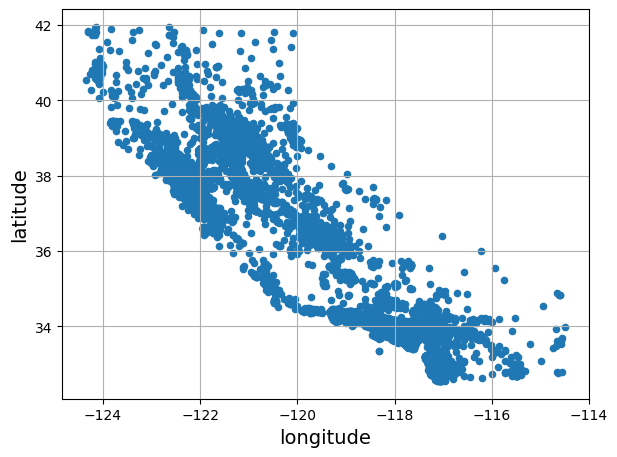

In [18]:
# Cria um gráfico de dispersão simples (longitude vs latitude)
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot") # Salva a figura
plt.show()

Este gráfico mostra a forma da Califórnia, mas é difícil ver padrões de densidade. Vamos ajustar a opacidade (`alpha`) para visualizar melhor as áreas de alta densidade.

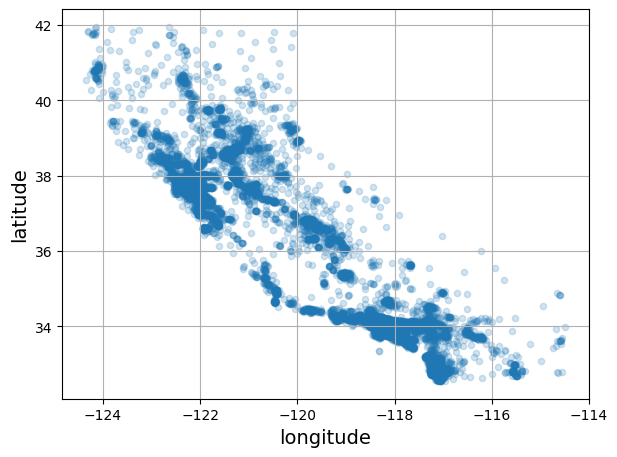

In [19]:
# Cria um gráfico de dispersão com alpha=0.2 para visualizar densidade
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot") # Salva a figura
plt.show()

Agora, vamos adicionar mais informações ao gráfico:
- O tamanho de cada círculo (`s`) representará a população do distrito.
- A cor (`c`) representará o preço mediano da casa (`median_house_value`).
- Usaremos um mapa de cores predefinido (`cmap="jet"`) que varia do azul (valores baixos) ao vermelho (valores altos).
- Adicionaremos uma barra de cores (`colorbar=True`) para indicar a escala de preços.

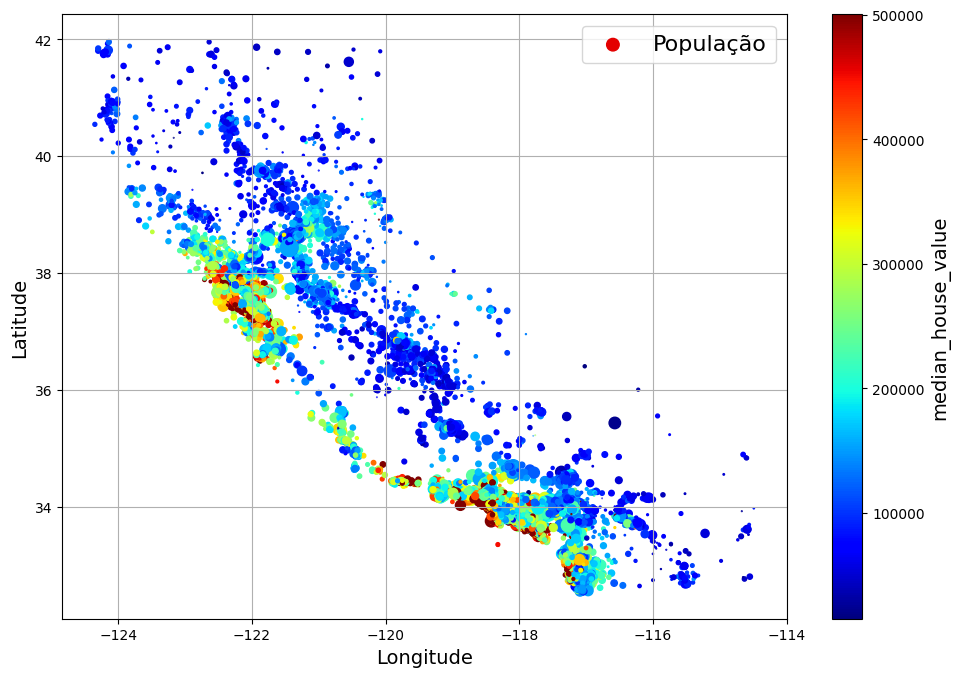

In [20]:
# Cria um gráfico de dispersão mais informativo
# s: tamanho do ponto baseado na população (dividido por 100 para melhor escala)
# c: cor baseada no valor mediano da casa
# cmap: mapa de cores 'jet'
# colorbar: adiciona a barra de legenda de cores
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="População",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.ylabel("Latitude", fontsize=14) # Adiciona rótulo ao eixo y
plt.xlabel("Longitude", fontsize=14) # Adiciona rótulo ao eixo x
plt.legend(fontsize=16) # Ajusta o tamanho da fonte da legenda
save_fig("housing_prices_scatterplot") # Salva a figura
plt.show()

Este gráfico revela que os preços das moradias estão muito relacionados à localização (por exemplo, perto do oceano) e à densidade populacional.

Podemos tornar a visualização ainda melhor sobrepondo o gráfico a uma imagem do mapa da Califórnia.

Baixando california.png
Download concluído.


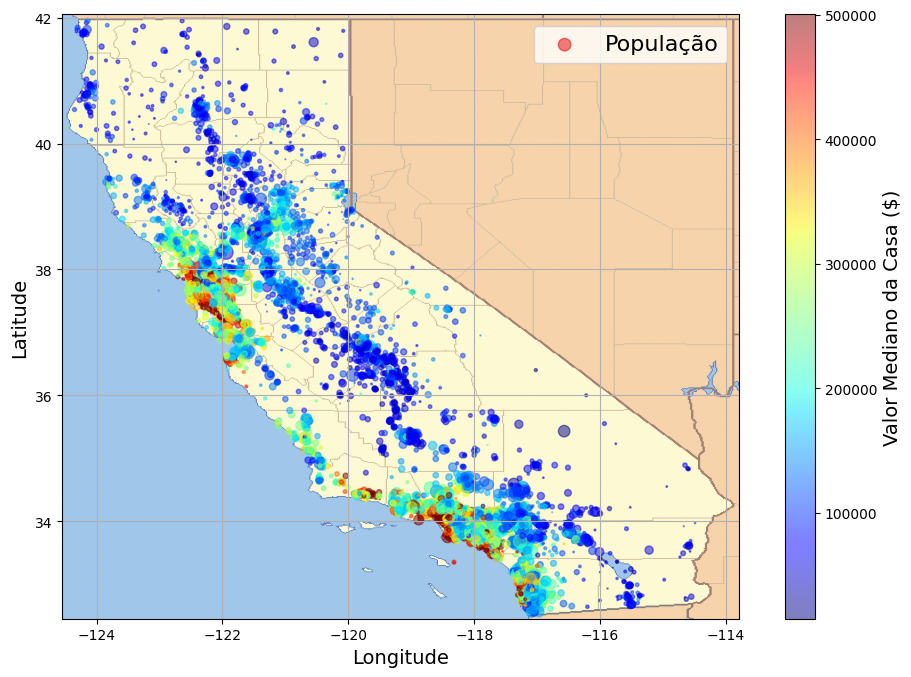

In [21]:
# Código extra para carregar a imagem do mapa da Califórnia e sobrepor o gráfico

# Baixa a imagem do mapa se não existir
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Baixando", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)
    print("Download concluído.")

# Carrega a imagem
california_img = plt.imread(IMAGES_PATH / filename)

# Define os limites do eixo para corresponder ao mapa
axis = [-124.55, -113.80, 32.45, 42.05]

# Cria a figura e os eixos
plt.figure(figsize=(10, 7))

# Plota a imagem do mapa
plt.imshow(california_img, extent=axis)

# Sobrepõe o gráfico de dispersão dos preços das casas
# Note que 'sharex=False' foi removido pois estamos usando plt diretamente
plt.scatter(housing["longitude"], housing["latitude"],
            s=housing["population"] / 100, label="População",
            c=housing["median_house_value"], cmap="jet",
            alpha=0.5) # Alpha ajustado para melhor visualização sobre o mapa

# Adiciona a barra de cores
plt.colorbar(label='Valor Mediano da Casa ($)')

# Adiciona rótulos e legenda
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)

# Ajusta os limites dos eixos
plt.axis(axis)
plt.grid(True) # Adiciona grade

save_fig("california_housing_prices_plot") # Salva a figura
plt.show()

# Procurando Correlações

Como o conjunto de dados não é muito grande, podemos calcular facilmente a matriz de correlação padrão (coeficiente de correlação de Pearson) entre todos os pares de atributos usando o método `.corr()` do Pandas.

In [22]:
# Calcula a matriz de correlação padrão para todos os atributos numéricos
corr_matrix_pd = housing.corr(numeric_only=True) # numeric_only=True para evitar warnings futuros

# Exibe a correlação de cada atributo com 'median_house_value'
# Ordena os valores em ordem decrescente para ver as correlações mais fortes
print("Correlação com 'median_house_value' (Pandas):")
print(corr_matrix_pd["median_house_value"].sort_values(ascending=False))

Correlação com 'median_house_value' (Pandas):
median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


### Calculando Correlações com PyTorch

Podemos também calcular a matriz de correlação usando PyTorch. Para isso, primeiro selecionamos apenas as colunas numéricas e as convertemos para um tensor PyTorch. Depois, usamos `torch.corrcoef()`.


Correlação com 'median_house_value' (PyTorch):
median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071427
total_bedrooms        0.054791
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float32


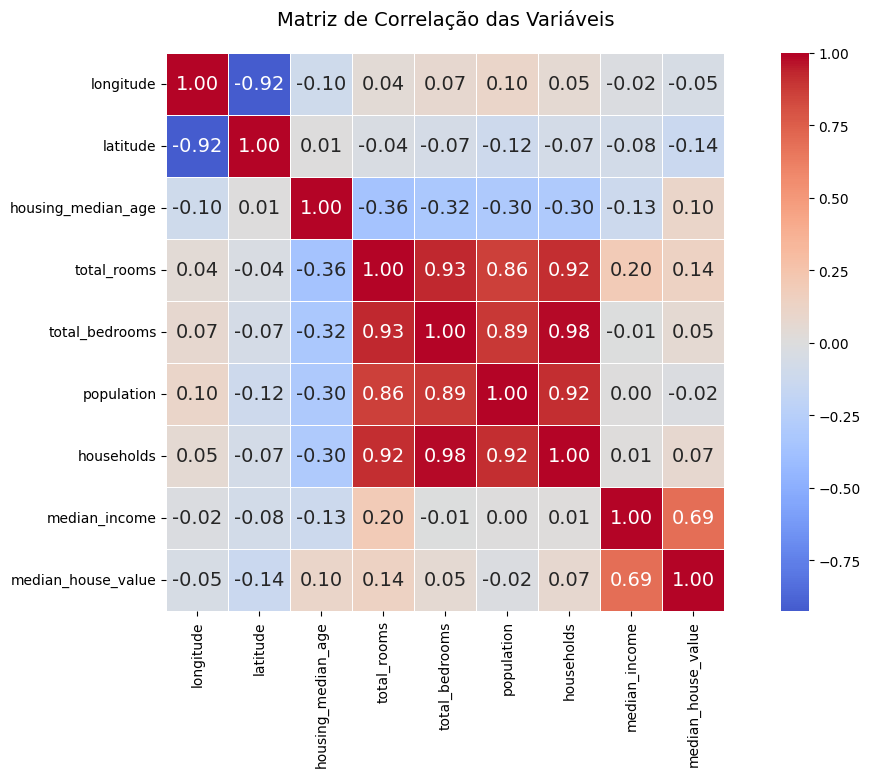

In [26]:
# Seleciona apenas as colunas numéricas do DataFrame
housing_numeric = housing.select_dtypes(include=[np.number])

# Converte o DataFrame numérico para um tensor PyTorch
# É importante lidar com valores NaN antes da conversão ou do cálculo da correlação.
# Aqui, vamos preencher NaNs com 0 para demonstração, mas uma estratégia melhor (imputação) será usada depois.
housing_tensor = torch.tensor(housing_numeric.fillna(0).values, dtype=torch.float32)

# Calcula a matriz de correlação usando PyTorch
# torch.corrcoef espera que as variáveis estejam nas linhas, então transpomos o tensor (T)
corr_matrix_torch = torch.corrcoef(housing_tensor.T)

# Converte a matriz de correlação do PyTorch de volta para um DataFrame do Pandas
# para facilitar a visualização e comparação com o resultado anterior
corr_matrix_pt_df = pd.DataFrame(corr_matrix_torch.numpy(),
                                 columns=housing_numeric.columns,
                                 index=housing_numeric.columns)

# Exibe a correlação de cada atributo com 'median_house_value' (calculada com PyTorch)
print("\nCorrelação com 'median_house_value' (PyTorch):")
print(corr_matrix_pt_df["median_house_value"].sort_values(ascending=False))

# Importar seaborn
import seaborn as sns

# Criar uma figura maior para melhor visualização
plt.figure(figsize=(12, 8))

# Criar um mapa de calor (heatmap) da matriz de correlação usando seaborn
sns.heatmap(corr_matrix_pd, 
            annot=True,  # Mostra os valores numéricos
            cmap='coolwarm',  # Esquema de cores (vermelho=positivo, azul=negativo)
            center=0,  # Centro da escala de cores em 0
            fmt='.2f',  # Formato dos números (2 casas decimais)
            square=True,  # Células quadradas
            linewidths=0.5)  # Largura das linhas entre células

plt.title('Matriz de Correlação das Variáveis', pad=20)
plt.tight_layout()
plt.show()



Outra forma de verificar a correlação entre atributos é usar a função `scatter_matrix` do Pandas (que usa Matplotlib por baixo), que plota cada atributo numérico contra todos os outros. Vamos focar em alguns atributos que parecem promissores em relação ao valor mediano da casa.

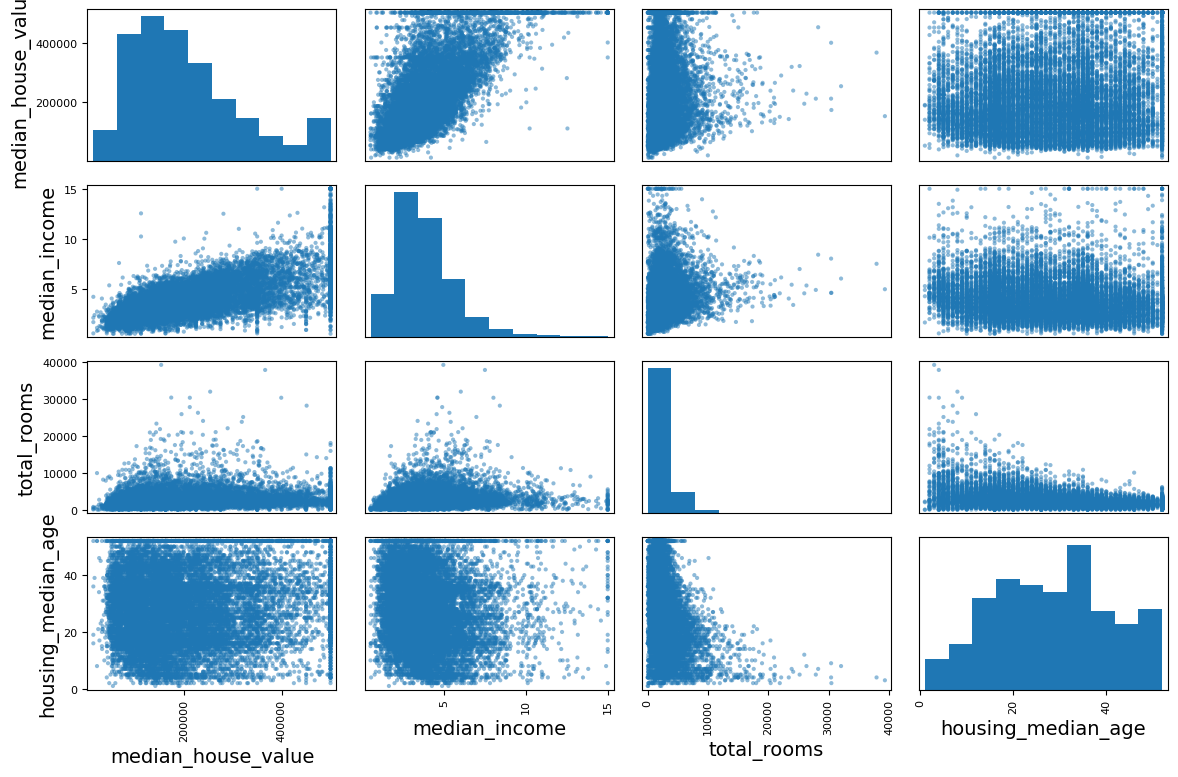

In [27]:
from pandas.plotting import scatter_matrix

# Lista de atributos para incluir na matriz de dispersão
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

# Gera a matriz de dispersão para os atributos selecionados
scatter_matrix(housing[attributes], figsize=(12, 8), grid=True)
save_fig("scatter_matrix_plot") # Salva a figura
plt.show()

O atributo mais promissor para prever o valor mediano da casa é a renda mediana (`median_income`). Vamos dar um zoom no gráfico de dispersão da correlação entre eles.

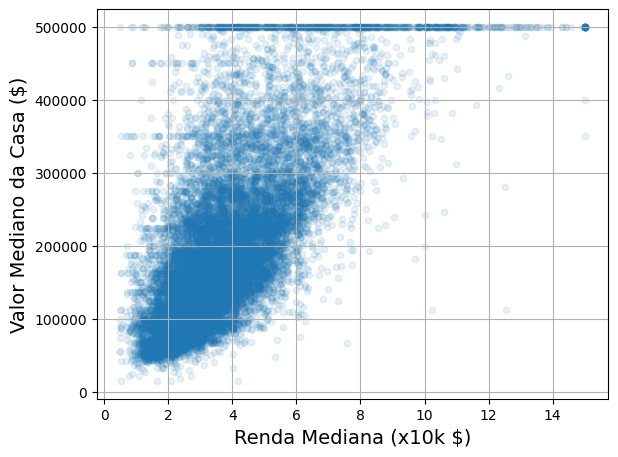

In [28]:
# Plota o gráfico de dispersão entre 'median_income' e 'median_house_value'
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True) # alpha baixo ajuda a ver a densidade
plt.xlabel("Renda Mediana (x10k $)") # Rótulo do eixo x
plt.ylabel("Valor Mediano da Casa ($)") # Rótulo do eixo y
save_fig("income_vs_house_value_scatterplot") # Salva a figura
plt.show()

Este gráfico mostra uma clara correlação positiva. Além disso, podemos notar alguns padrões:
1.  Um limite superior de preço em $500.000 (um *cap* nos dados).
2.  Algumas linhas horizontais em torno de $450.000, $350.000 e talvez $280.000, que podem ser peculiaridades dos dados. Tentaremos removê-las.

# Experimentando Combinações de Atributos

Uma ideia é tentar várias combinações de atributos. Por exemplo, o número total de cômodos ou quartos em um distrito não é muito útil se não soubermos quantos domicílios existem. O que realmente queremos é o número de cômodos por domicílio. Da mesma forma, o número total de quartos por si só não é tão interessante quanto a proporção de quartos por cômodo. E a população por domicílio também parece ser um atributo interessante. Vamos criar essas novas características.

In [29]:
# Cria novas características combinando as existentes
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

print("Novas características criadas:")
print(housing[["rooms_per_household", "bedrooms_per_room", "population_per_household"]].head())

Novas características criadas:
       rooms_per_household  bedrooms_per_room  population_per_household
13096             3.211799           0.335742                  1.524178
14973             5.504202           0.180153                  1.865546
3785              5.334975           0.200369                  2.768473
14689             5.351282           0.203881                  2.365385
20507             3.725256           0.277371                  1.631399


Agora, vamos recalcular a matriz de correlação, incluindo essas novas características, para ver se elas têm uma correlação mais forte com `median_house_value`. Faremos isso com Pandas e também com PyTorch.

In [30]:
# Calcula a matriz de correlação com Pandas, incluindo as novas características
corr_matrix_pd_new = housing.corr(numeric_only=True)
print("Correlação com 'median_house_value' (Pandas, com novas características):")
print(corr_matrix_pd_new["median_house_value"].sort_values(ascending=False))

# Seleciona colunas numéricas (incluindo as novas)
housing_numeric_new = housing.select_dtypes(include=[np.number])

# Converte para tensor PyTorch (preenchendo NaNs com 0 para demonstração)
# Lembre-se que a imputação adequada será feita depois.
# A coluna 'bedrooms_per_room' também terá NaNs se 'total_bedrooms' ou 'total_rooms' forem NaN ou 0.
housing_tensor_new = torch.tensor(housing_numeric_new.fillna(0).values, dtype=torch.float32)

# Calcula a matriz de correlação com PyTorch
corr_matrix_torch_new = torch.corrcoef(housing_tensor_new.T)

# Converte de volta para DataFrame Pandas para visualização
corr_matrix_pt_df_new = pd.DataFrame(corr_matrix_torch_new.numpy(),
                                     columns=housing_numeric_new.columns,
                                     index=housing_numeric_new.columns)

# Exibe a correlação com PyTorch
print("\nCorrelação com 'median_house_value' (PyTorch, com novas características):")
print(corr_matrix_pt_df_new["median_house_value"].sort_values(ascending=False))

# Nota: 'bedrooms_per_room' agora mostra uma correlação negativa mais forte com o preço
# (casas com menor proporção quarto/cômodo tendem a ser mais caras).
# 'rooms_per_household' é um pouco mais informativa que 'total_rooms'.

Correlação com 'median_house_value' (Pandas, com novas características):
median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

Correlação com 'median_house_value' (PyTorch, com novas características):
median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054791
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.0508

# Preparar os Dados para Algoritmos de Machine Learning

É hora de preparar os dados para os modelos. Em vez de fazer isso manualmente, devemos escrever funções ou usar as ferramentas do Scikit-Learn para facilitar a reprodução dessas transformações em novos dados (como o conjunto de teste) ou em um sistema em produção.

Primeiro, vamos reverter para um conjunto de treinamento limpo (sem as colunas combinadas que criamos para exploração) e separar os preditores (`housing`) da variável alvo (`housing_labels`).

In [31]:
# Reverte para o conjunto de treinamento original (estratificado)
# drop() remove a coluna alvo 'median_house_value' do conjunto de preditores
housing = strat_train_set.drop("median_house_value", axis=1)
# Cria uma série separada com a coluna alvo
housing_labels = strat_train_set["median_house_value"].copy()

print("Preditores (features) e rótulos (labels) separados.")
print("Dimensões dos preditores:", housing.shape)
print("Dimensões dos rótulos:", housing_labels.shape)

Preditores (features) e rótulos (labels) separados.
Dimensões dos preditores: (16512, 9)
Dimensões dos rótulos: (16512,)


## Limpeza de Dados

A maioria dos algoritmos de Machine Learning não funciona com dados ausentes. Vimos anteriormente que `total_bedrooms` tem valores faltantes. Temos três opções:

1.  Remover os distritos correspondentes (linhas).
2.  Remover o atributo inteiro (`total_bedrooms`).
3.  Preencher os valores ausentes (com zero, a média, a mediana, etc.).

Vamos usar a terceira opção, preenchendo com a mediana, usando a classe `SimpleImputer` do Scikit-Learn. Primeiro, precisamos lidar apenas com os dados numéricos, pois a mediana só pode ser calculada neles.

In [32]:
from sklearn.impute import SimpleImputer

# Cria uma instância do SimpleImputer, especificando que queremos preencher com a mediana
imputer = SimpleImputer(strategy="median")

# Separa apenas as colunas numéricas, pois a imputação será feita nelas
housing_num = housing.select_dtypes(include=[np.number])

# Ajusta ('fit') o imputer aos dados numéricos de treinamento
# Isso calcula a mediana para cada coluna numérica
imputer.fit(housing_num)

# O imputer calculou a mediana de cada atributo e armazenou em 'statistics_'
print("Medianas calculadas pelo Imputer:")
print(imputer.statistics_)

# Verifica se as medianas calculadas manualmente correspondem
print("\nMedianas calculadas manualmente (Pandas):")
print(housing_num.median().values)

# Agora, usamos o imputer 'treinado' para transformar ('transform') o conjunto de treinamento,
# substituindo os valores ausentes pela mediana calculada.
# O resultado é um array NumPy.
X_num_imputed = imputer.transform(housing_num)

# Podemos converter o array NumPy de volta para um DataFrame Pandas para visualização (opcional)
housing_num_tr = pd.DataFrame(X_num_imputed, columns=housing_num.columns,
                              index=housing_num.index)

print("\nPrimeiras linhas dos dados numéricos após imputação:")
print(housing_num_tr.head())
print("\nVerificando valores ausentes após imputação:")
print(housing_num_tr.isnull().sum()) # Não deve haver mais valores ausentes

Medianas calculadas pelo Imputer:
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]

Medianas calculadas manualmente (Pandas):
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]

Primeiras linhas dos dados numéricos após imputação:
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
2

## Lidando com Atributos Categóricos e de Texto

Até agora, lidamos apenas com os atributos numéricos. Vamos agora processar o atributo categórico `ocean_proximity`. A maioria dos modelos prefere trabalhar com números. Vamos converter essas categorias em números usando o `OneHotEncoder` do Scikit-Learn. Ele cria uma coluna binária para cada categoria.

In [33]:
from sklearn.preprocessing import OneHotEncoder

# Seleciona a coluna categórica
housing_cat = housing[["ocean_proximity"]] # Colchetes duplos mantêm como DataFrame

# Cria uma instância do OneHotEncoder
# sparse_output=False retorna um array NumPy denso em vez de uma matriz esparsa
cat_encoder = OneHotEncoder(sparse_output=False)

# Ajusta e transforma a coluna categórica
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

print("Formato dos dados categóricos após One-Hot Encoding:", housing_cat_1hot.shape)
print("\nCategorias encontradas pelo encoder:", cat_encoder.categories_)
print("\nArray resultante do One-Hot Encoding (primeiras 5 linhas):")
print(housing_cat_1hot[:5])

Formato dos dados categóricos após One-Hot Encoding: (16512, 5)

Categorias encontradas pelo encoder: [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]

Array resultante do One-Hot Encoding (primeiras 5 linhas):
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


## Escalonamento de Atributos (Feature Scaling)

Algoritmos de Machine Learning geralmente não performam bem quando os atributos numéricos de entrada têm escalas muito diferentes. Existem duas maneiras comuns de colocar todos os atributos na mesma escala: normalização (min-max scaling) e padronização (standardization).

*   **Normalização:** Os valores são deslocados e reescalonados para que acabem variando de 0 a 1. Usamos `MinMaxScaler`.
*   **Padronização:** Primeiro subtrai o valor médio (então os valores padronizados sempre têm média zero) e depois divide pelo desvio padrão (então os valores padronizados sempre têm variância 1). Usamos `StandardScaler`. Padronização é menos afetada por outliers.

Vamos aplicar a padronização aos dados numéricos (já imputados).

In [34]:
from sklearn.preprocessing import StandardScaler

# Cria uma instância do StandardScaler
scaler = StandardScaler()

# Ajusta e transforma os dados numéricos (já imputados)
# Lembre-se: usamos X_num_imputed que é o array NumPy resultante da imputação
X_num_imputed_scaled = scaler.fit_transform(X_num_imputed)

# Converte de volta para DataFrame para visualização (opcional)
housing_num_scaled_tr = pd.DataFrame(X_num_imputed_scaled, columns=housing_num.columns,
                                     index=housing_num.index)

print("Dados numéricos após padronização (primeiras 5 linhas):")
print(housing_num_scaled_tr.head())
print("\nMédia após padronização (deve ser próxima de 0):")
print(housing_num_scaled_tr.mean(axis=0).round(2))
print("\nDesvio padrão após padronização (deve ser próximo de 1):")
print(housing_num_scaled_tr.std(axis=0).round(2))

Dados numéricos após padronização (primeiras 5 linhas):
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096  -1.423037  1.013606            1.861119     0.311912        1.368167   
14973   0.596394 -0.702103            0.907630    -0.308620       -0.435925   
3785   -1.203098  1.276119            0.351428    -0.712240       -0.760709   
14689   1.231216 -0.884924           -0.919891     0.702262        0.742306   
20507   0.711362 -0.875549            0.589800     0.790125        1.595753   

       population  households  median_income  
13096    0.137460    1.394812      -0.936491  
14973   -0.693771   -0.373485       1.171942  
3785    -0.788768   -0.775727      -0.759789  
14689    0.383175    0.731375      -0.850281  
20507    0.444376    1.755263      -0.180365  

Média após padronização (deve ser próxima de 0):
longitude            -0.0
latitude             -0.0
housing_median_age   -0.0
total_rooms          -0.0
total_bedrooms        0.0
populat

## Pipelines de Transformação

Como você pode ver, existem muitas etapas de transformação de dados que precisam ser executadas na ordem correta. O Scikit-Learn fornece a classe `Pipeline` para ajudar com essas sequências de transformações.

Vamos criar um pipeline para os atributos numéricos que realiza a imputação e o escalonamento.

In [35]:
from sklearn.pipeline import Pipeline

# Cria um pipeline para transformações numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Etapa 1: Imputação com mediana
    ('scaler', StandardScaler()),                 # Etapa 2: Padronização
])

# Aplica o pipeline aos dados numéricos originais (housing_num)
# O pipeline executa fit_transform sequencialmente
housing_num_prepared = num_pipeline.fit_transform(housing_num)

print("Formato dos dados numéricos após processamento pelo pipeline:", housing_num_prepared.shape)
print("\nDados numéricos preparados (primeiras 5 linhas do array NumPy):")
print(housing_num_prepared[:5].round(2))

Formato dos dados numéricos após processamento pelo pipeline: (16512, 8)

Dados numéricos preparados (primeiras 5 linhas do array NumPy):
[[-1.42  1.01  1.86  0.31  1.37  0.14  1.39 -0.94]
 [ 0.6  -0.7   0.91 -0.31 -0.44 -0.69 -0.37  1.17]
 [-1.2   1.28  0.35 -0.71 -0.76 -0.79 -0.78 -0.76]
 [ 1.23 -0.88 -0.92  0.7   0.74  0.38  0.73 -0.85]
 [ 0.71 -0.88  0.59  0.79  1.6   0.44  1.76 -0.18]]


Agora, precisamos de uma forma de aplicar transformações diferentes para colunas numéricas e categóricas. O Scikit-Learn tem o `ColumnTransformer` para isso. Ele aplica transformadores específicos a subconjuntos de colunas do DataFrame.

Vamos criar um `ColumnTransformer` que:
1. Aplica o `num_pipeline` às colunas numéricas.
2. Aplica o `OneHotEncoder` à coluna categórica `ocean_proximity`.

In [36]:
from sklearn.compose import ColumnTransformer

# Lista de colunas numéricas
num_attribs = list(housing.select_dtypes(include=[np.number]))
# Lista de colunas categóricas
cat_attribs = ["ocean_proximity"]

# Cria o ColumnTransformer
# O primeiro argumento é uma lista de tuplas: (nome, transformador, colunas)
preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),   # Aplica num_pipeline às colunas num_attribs
    ("cat", OneHotEncoder(sparse_output=False), cat_attribs), # Aplica OneHotEncoder a cat_attribs
])

# Aplica o ColumnTransformer ao DataFrame original 'housing' (sem os rótulos)
# Ele processa colunas numéricas e categóricas separadamente e concatena os resultados
housing_prepared = preprocess_pipeline.fit_transform(housing)

print("Formato dos dados após pré-processamento completo:", housing_prepared.shape)
print("\nDados preparados (primeiras 5 linhas do array NumPy):")
# Mostra apenas as primeiras 10 colunas para legibilidade
print(housing_prepared[:5, :10].round(2))

# Guarda os nomes das features após o pré-processamento (útil mais tarde)
feature_names = preprocess_pipeline.get_feature_names_out()
print("\nNomes das features após pré-processamento (exemplo):")
print(feature_names[:12]) # Mostra os primeiros nomes

Formato dos dados após pré-processamento completo: (16512, 13)

Dados preparados (primeiras 5 linhas do array NumPy):
[[-1.42  1.01  1.86  0.31  1.37  0.14  1.39 -0.94  0.    0.  ]
 [ 0.6  -0.7   0.91 -0.31 -0.44 -0.69 -0.37  1.17  1.    0.  ]
 [-1.2   1.28  0.35 -0.71 -0.76 -0.79 -0.78 -0.76  0.    1.  ]
 [ 1.23 -0.88 -0.92  0.7   0.74  0.38  0.73 -0.85  0.    1.  ]
 [ 0.71 -0.88  0.59  0.79  1.6   0.44  1.76 -0.18  0.    0.  ]]

Nomes das features após pré-processamento (exemplo):
['num__longitude' 'num__latitude' 'num__housing_median_age'
 'num__total_rooms' 'num__total_bedrooms' 'num__population'
 'num__households' 'num__median_income' 'cat__ocean_proximity_<1H OCEAN'
 'cat__ocean_proximity_INLAND' 'cat__ocean_proximity_ISLAND'
 'cat__ocean_proximity_NEAR BAY']


# Treinar o modelo em pytorch

Finalmente! Pré-processamos os dados. Agora podemos selecionar e treinar um modelo de machine learning.

## Regressão 

Agora, vamos implementar um modelo usando PyTorch. Isso envolve definir o modelo, a função de loss, o otimizador e o loop de treinamento.

### Preparação dos Dados para PyTorch

Primeiro, precisamos converter nossos dados preparados (NumPy arrays) em tensores PyTorch. Também criaremos `TensorDataset` e `DataLoader` para facilitar o treinamento em lotes (batches).

In [38]:
# Converte os dados preparados e os rótulos para tensores PyTorch
# housing_prepared já é um NumPy array
# housing_labels é uma Series Pandas, pegamos os valores .values
X_tensor = torch.tensor(housing_prepared, dtype=torch.float32)
y_tensor = torch.tensor(housing_labels.values, dtype=torch.float32).view(-1, 1) # .view(-1, 1) para garantir formato [n_samples, 1]

# Cria um TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Define o tamanho do batch
batch_size = 64

# Cria um DataLoader para iterar sobre os dados em batches
# shuffle=True embaralha os dados a cada época
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dados convertidos para tensores PyTorch. Tamanho do dataset: {len(dataset)}, Tamanho do batch: {batch_size}")

Dados convertidos para tensores PyTorch. Tamanho do dataset: 16512, Tamanho do batch: 64


### Definição do Modelo, Loss e Otimizador

In [86]:
n_features = housing_prepared.shape[1] # Número de features após pré-processamento
model_pt = nn.Sequential(
    nn.Linear(n_features, 512),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(), 
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1)
)


criterion = nn.MSELoss()

optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

print("Modelo PyTorch, Função de Loss e Otimizador definidos.")
print(model_pt)

Modelo PyTorch, Função de Loss e Otimizador definidos.
Sequential(
  (0): Linear(in_features=13, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=64, out_features=1, bias=True)
)


### Loop de Treinamento

Iniciando treinamento do modelo PyTorch...
Época [100/1000], Loss (MSE): 3476313658.5426
Época [200/1000], Loss (MSE): 3147601073.6124
Época [300/1000], Loss (MSE): 2999414816.7442
Época [400/1000], Loss (MSE): 2898442516.8372
Época [500/1000], Loss (MSE): 2841544629.8295
Época [600/1000], Loss (MSE): 2746383028.3411
Época [700/1000], Loss (MSE): 2721230097.8605
Época [800/1000], Loss (MSE): 2686666450.3566
Época [900/1000], Loss (MSE): 2591891202.9767
Época [1000/1000], Loss (MSE): 2497781744.1240
Treinamento concluído.


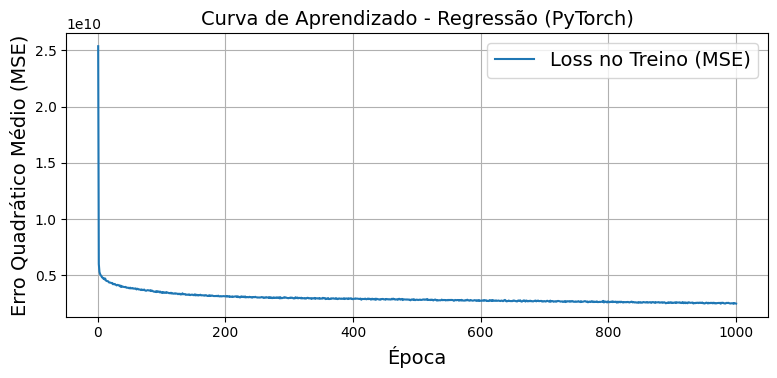

In [87]:
# Define o número de épocas de treinamento
n_epochs = 1000
train_losses = [] # Para armazenar o histórico de perdas

print("Iniciando treinamento do modelo PyTorch...")

# Loop de treinamento
for epoch in range(n_epochs):
    model_pt.train() # Coloca o modelo em modo de treinamento
    epoch_loss = 0.0

    # Itera sobre os batches de dados
    for inputs, targets in train_loader:
        # 1. Zera os gradientes acumulados do otimizador
        optimizer.zero_grad()

        # 2. Faz a previsão (forward pass)
        outputs = model_pt(inputs)

        # 3. Calcula a perda
        loss = criterion(outputs, targets)

        # 4. Calcula os gradientes (backward pass)
        loss.backward()

        # 5. Atualiza os pesos do modelo
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0) # Acumula a perda do batch

    # Calcula a perda média da época
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Imprime o progresso a cada 10 épocas
    if (epoch + 1) % 100 == 0:
        print(f"Época [{epoch+1}/{n_epochs}], Loss (MSE): {epoch_loss:.4f}")

print("Treinamento concluído.")

# Plota a curva de aprendizado (perda ao longo das épocas)
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_epochs + 1), train_losses, label='Loss no Treino (MSE)')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.title('Curva de Aprendizado - Regressão (PyTorch)')
plt.legend()
plt.grid(True)
save_fig("pytorch_linear_regression_learning_curve")
plt.show()

### Avaliação do Modelo PyTorch

Agora, vamos avaliar o modelo PyTorch treinado no conjunto de treinamento completo e calcular o RMSE.

In [88]:
# Avalia o modelo PyTorch treinado
from sklearn.metrics import mean_squared_error


model_pt.eval() # Coloca o modelo em modo de avaliação (desativa dropout, etc.)

# Faz previsões no conjunto de treinamento completo
with torch.no_grad(): # Desabilita cálculo de gradientes para avaliação
    housing_predictions_pt = model_pt(X_tensor)

# Calcula o MSE e RMSE
# .numpy() converte o tensor PyTorch de volta para NumPy array
lin_mse_pt = mean_squared_error(y_tensor.numpy(), housing_predictions_pt.numpy())
lin_rmse_pt = np.sqrt(lin_mse_pt)

print(f"\nRMSE da Regressão no treino: ${lin_rmse_pt:,.2f}")


RMSE da Regressão no treino: $43,417.13


# Avaliar o Modelo no Conjunto de Teste

In [89]:
# Obtém o modelo PyTorch treinado
model_pt.eval()  # Coloca o modelo em modo de avaliação

# Separa os preditores (X_test) e os rótulos (y_test) do conjunto de teste estratificado
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Aplica o pipeline de pré-processamento aos dados de teste
X_test_prepared = preprocess_pipeline.transform(X_test)

print("Dados de teste pré-processados.")
print("Formato dos dados de teste preparados:", X_test_prepared.shape)

# Converte os dados de teste para tensor PyTorch
X_test_tensor = torch.FloatTensor(X_test_prepared)

# Faz as previsões no conjunto de teste usando o modelo PyTorch
with torch.no_grad():  # Desabilita cálculo de gradientes para avaliação
    final_predictions = model_pt(X_test_tensor)

# Converte as previsões de tensor para numpy array
final_predictions = final_predictions.numpy()

# Calcula o MSE e o RMSE finais no conjunto de teste
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"\nRMSE Final no Conjunto de Teste: ${final_rmse:,.2f}")
# Este valor é a estimativa do desempenho do seu modelo em produção (em dados novos).

Dados de teste pré-processados.
Formato dos dados de teste preparados: (4128, 13)

RMSE Final no Conjunto de Teste: $51,474.98


In [90]:
from scipy import stats

confidence = 0.95 # Define o nível de confiança (95%)

# Converte as previsões e valores reais para numpy arrays
final_predictions_np = final_predictions.flatten() # Achata o array para 1D
y_test_np = y_test.values

# Calcula os erros quadráticos
squared_errors = (final_predictions_np - y_test_np) ** 2

# Calcula o intervalo de confiança para a média dos erros quadráticos
# Usa a distribuição t de Student
confidence_interval = stats.t.interval(confidence,
                                     len(squared_errors) - 1, # Graus de liberdade
                                     loc=squared_errors.mean(), # Média amostral (MSE)
                                     scale=stats.sem(squared_errors)) # Erro padrão da média (SEM)

# Tira a raiz quadrada dos limites do intervalo para obter o intervalo de confiança do RMSE
rmse_interval = np.sqrt(confidence_interval)

print(f"\nIntervalo de Confiança de {confidence*100}% para o RMSE no teste: [{rmse_interval[0]:.2f}, {rmse_interval[1]:.2f}]")


Intervalo de Confiança de 95.0% para o RMSE no teste: [48865.78, 53958.15]


## Visualizar predições do modelo versus Valores Reais

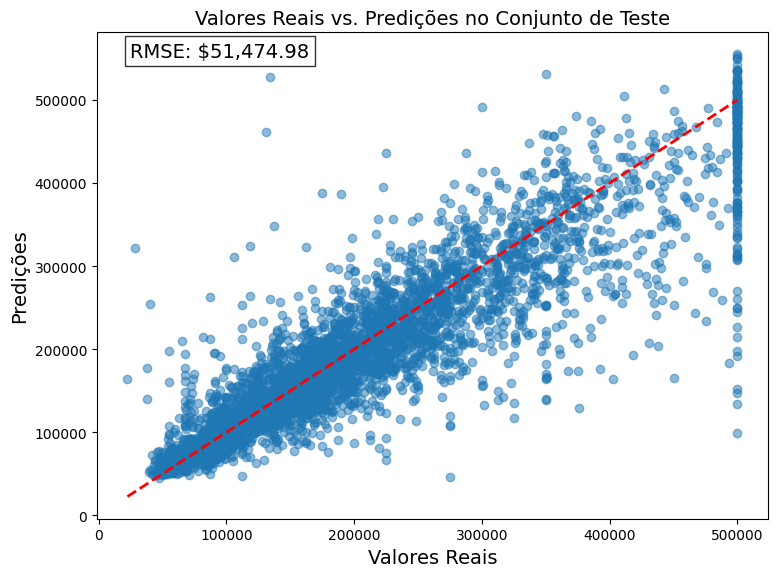

In [91]:
# Cria um gráfico de dispersão comparando valores reais vs. preditos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Predições')
plt.title('Valores Reais vs. Predições no Conjunto de Teste')

# Adiciona texto com o RMSE
plt.text(0.05, 0.95, f'RMSE: ${final_rmse:,.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


**Fim do Projeto!**